## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

import tensorflow as tf

import mimic_iv_utils as utils

from functools import reduce

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

## 2. Fetch Data

In [2]:
static = utils.getStaticFeatures()
first_lab = utils.getLabFeatures(duration=24)
last_lab = utils.getLabFeatures(mode='last', duration=24)
first_vitals = utils.getVitalsFeatures(duration=24)
last_vitals = utils.getVitalsFeatures(mode='last', duration=24)
max_vitals = utils.getMinMaxVitalsFeatures(mode='max', duration=24)
min_vitals = utils.getMinMaxVitalsFeatures(duration=24)
avg_vitals = utils.getMinMaxVitalsFeatures(mode='avg', duration=24)
mortality = utils.getInhospitalMortality()
filtered = utils.getFilteredCohort(duration=24)

dfs = [filtered, static, first_lab, last_lab, first_vitals, last_vitals, max_vitals, min_vitals, avg_vitals, mortality]
data = reduce(lambda  left, right: pd.merge(left, right, on=['stay_id'], how='inner'), dfs)

data.drop(columns=['subject_id', 'hadm_id', 'stay_id'], inplace=True)

X = data.values
y = X[:,-1]
y = y.astype('int')
X = X[:,0:-1]
X_header = [x for x in data.columns.values]
X_header = X_header[0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Missing Data

<BarContainer object of 115 artists>

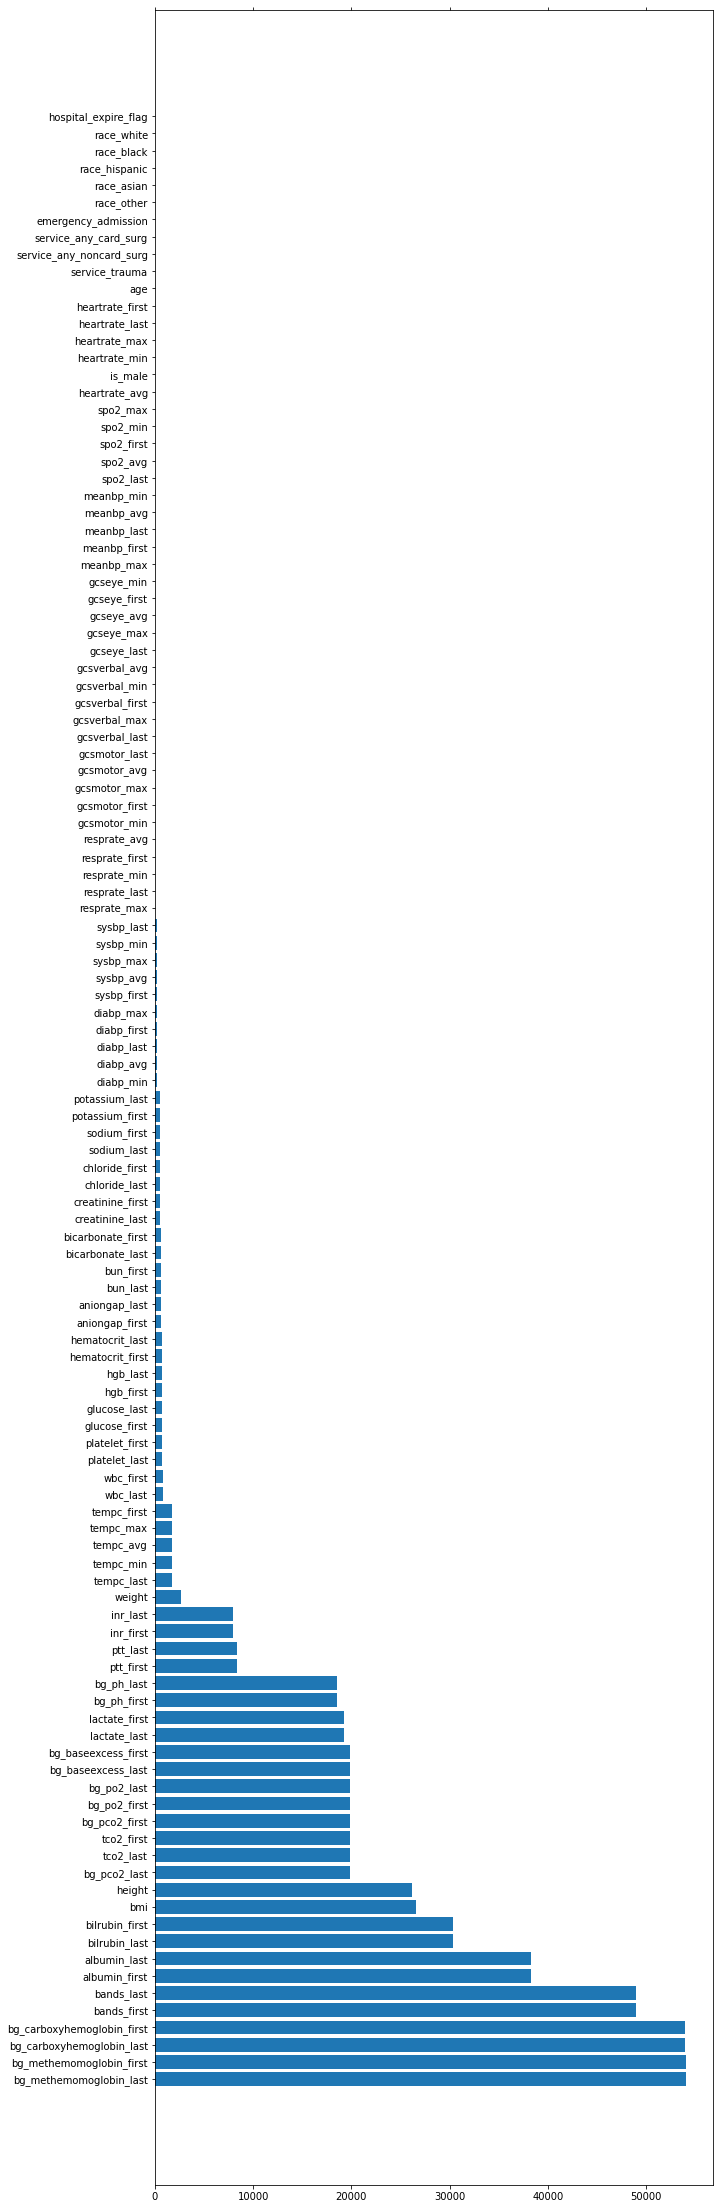

In [3]:
na_counts = data.isna().sum().reset_index(name="n")
na_counts = na_counts.sort_values(by=['n'], ascending=[False])
na_counts.rename(columns={'index' : 'feature'}, inplace=True)
plt.figure(figsize=(10,40))
plt.tick_params(top="on")
plt.barh(y=na_counts.feature, width=na_counts.n)

## 4. Feature Importance

In [4]:
estimator = Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                      ("scaler", StandardScaler()),
                      ("xgb" , xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))])
mdl = estimator.fit(X_train, y_train)
probs = mdl.predict_proba(X_test)
probs = probs[:,1]
preds = mdl.predict(X_test)

/superbugai-data/yash/chapter_1/workspace/MIMIC_Extract/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
feature_importance_list = []
feature_imp_dict = mdl.named_steps['xgb'].get_booster().get_score(importance_type="gain")
for feature_imp in feature_imp_dict:
    feature_importance_list.append([X_header[int(feature_imp[1:])], feature_imp_dict[feature_imp]])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)

<BarContainer object of 101 artists>

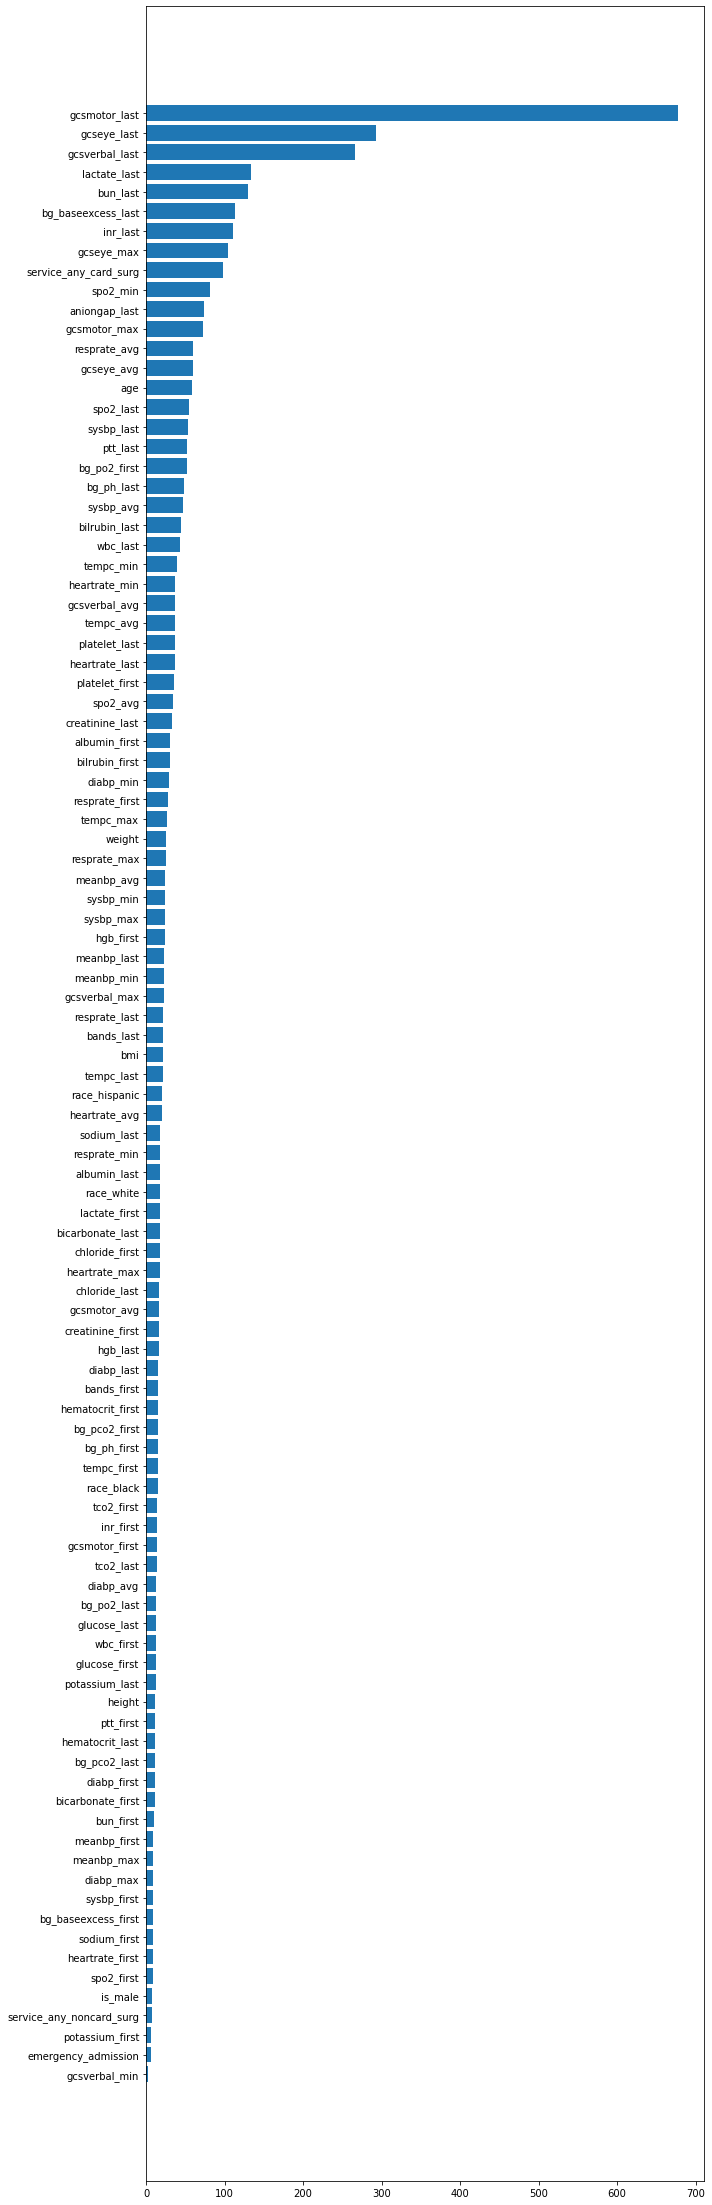

In [6]:
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## 5. Important Feature with Missing Values

In [7]:
df = pd.merge(xgbDf, na_counts, on=['feature'], how='inner')
df['missing_ratio'] = df.n/data.shape[0]
df['rank'] = df.weight.rank()

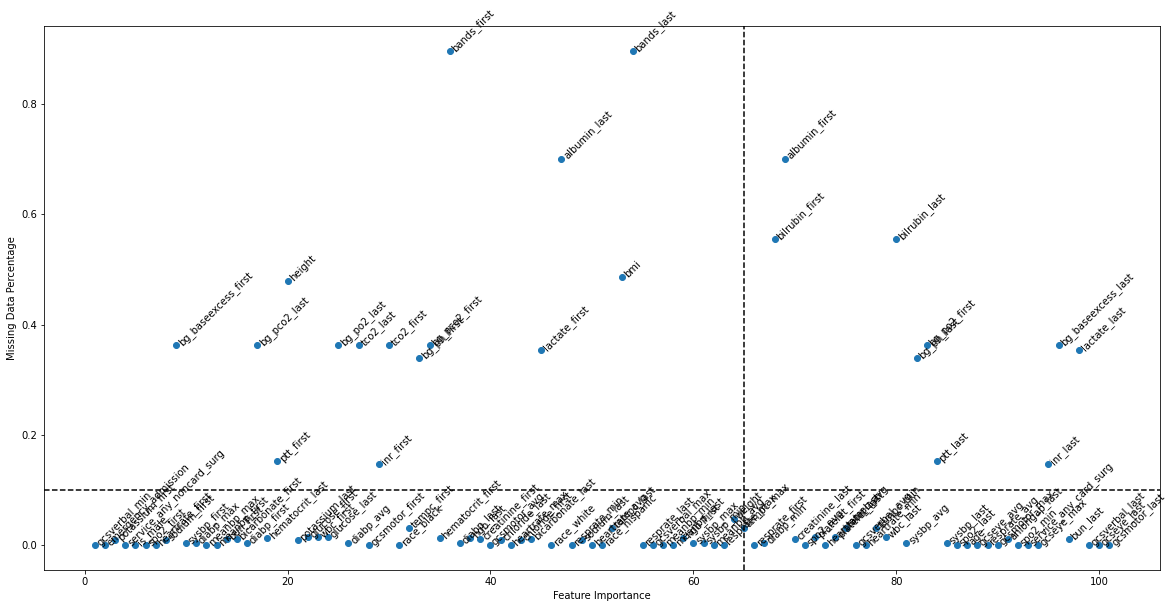

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(df['rank'], df.missing_ratio)
for i, txt in enumerate(df.feature):
    plt.annotate(txt, (df['rank'][i], df.missing_ratio[i]), rotation=45.0)
plt.axvline(x=65, color='k', linestyle='--')
plt.axhline(y=0.1, color='k', linestyle='--')
plt.xlabel('Feature Importance')
plt.ylabel('Missing Data Percentage')
plt.show()

In [11]:
df[(df.missing_ratio >= 0.1) & (df['rank'] >= 65)]

,feature,weight,n,missing_ratio,rank
67,bilrubin_first,29.873343,30336,0.555533,68.0
68,albumin_first,29.916334,38285,0.701101,69.0
79,bilrubin_last,44.856846,30336,0.555533,80.0
81,bg_ph_last,47.751088,18500,0.338784,82.0
82,bg_po2_first,51.965256,19827,0.363085,83.0
83,ptt_last,52.109075,8352,0.152947,84.0
94,inr_last,110.029324,7991,0.146337,95.0
95,bg_baseexcess_last,113.023714,19824,0.363030,96.0
97,lactate_last,133.395719,19292,0.353288,98.0
